In [7]:
################################################################
# Load packages
################################################################

from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import openmmplumed
import mdtraj as md
import numpy as np
from openmm.app import modeller
from openmm.app.pdbfile import PDBFile
import pandas as pd
import matplotlib.pyplot as plt
from parmed import load_file

In [11]:
################################################################
# Choose hyperparameters
################################################################
directory = './aib9_openmm/'

gro = load_file(directory + 'aib9.gro')
top = load_file(directory + 'topol.top')

top.box = gro.box[:] # load periodic boundary definition from .gro

plumed_file = 'plumed_script.dat'
sim_temp = 500.00 # simulation temperature in kelvin
prefix = 'production_run_'
integration_timestep = 0.002 # 2 femtoseconds
simulation_steps = 5000000 # 10 nanoseconds -> increase this to run longer simulations

NVT_steps =  500000 # 1 ns NVT -> no need to change
NPT_steps =  1000000 # 2 ns NPT equilibration -> no need to change
traj_frame_freq = 5000 # saves all atom coordinates as .dcd trajectory every 10 picoseconds
colvar_save_freq = 100 # computes and saves phi,psi dihedral angles every 200 femtoseconds
stdout_freq = 10000 # prints key system indicators every 20 picoseconds in console  -> no need to change
################################################################
def run_simulation():
    system = top.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*nanometers, constraints=app.HBonds)
    integrator = LangevinMiddleIntegrator(sim_temp*kelvin, 1/picosecond, integration_timestep*picoseconds)
    simulation = Simulation(top.topology, system, integrator)
    simulation.context.setPositions(gro.positions)
    
    print("Minimizing energy")
    simulation.minimizeEnergy()
    lastpositions = simulation.context.getState(getPositions=True).getPositions()
    app.PDBFile.writeFile(top.topology, lastpositions, open(directory + prefix +  'ener_minim.pdb', 'w'))
    
    print("Running NVT")
    simulation.step(NVT_steps)
    lastpositions = simulation.context.getState(getPositions=True).getPositions()
    app.PDBFile.writeFile(top.topology, lastpositions, open(directory + prefix +  'NVT.pdb', 'w'))
    
    system.addForce(MonteCarloBarostat(1*bar, sim_temp*kelvin))
    simulation.context.reinitialize(preserveState=True)
    print("Running NPT")
    simulation.step(NPT_steps)
    lastpositions = simulation.context.getState(getPositions=True).getPositions()
    app.PDBFile.writeFile(top.topology, lastpositions, open(directory + prefix +  'NPT.pdb', 'w'))
    
    print("System setup (energy minimization + equilibration) complete!")
    
    
    print("Starting production simulation!")
    simulation.reporters.append(DCDReporter(directory + prefix + '0.dcd', traj_frame_freq))
    simulation.reporters.append(StateDataReporter(stdout, stdout_freq, time = True, step=True, speed = True, potentialEnergy=True, kineticEnergy = True, temperature=True, volume=True, density=True, elapsedTime=True))
    
    lastpositions = simulation.context.getState(getPositions=True).getPositions()
    app.PDBFile.writeFile(top.topology, lastpositions, open(directory + prefix + '0.pdb', 'w'))
    
    with open(directory + plumed_file) as f:
            script = f.read()
            script = script.format(colvar_save_freq, colvar_save_freq)
        
    system.addForce(openmmplumed.PlumedForce(script))
    simulation.context.reinitialize(preserveState=True)
    
    simulation.step(simulation_steps)
    
    
    print("Production simulation complete!")

In [13]:
run_simulation()

Minimizing energy
Running NVT
Running NPT
System setup (energy minimization + equilibration) complete!
Starting production simulation!
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.3 (git: Unknown) compiled on Dec  1 2021 at 12:51:58
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /data/mehdis2/conda/envs/openmm/lib/plumed
PLUMED: For installed feature, see /data/mehdis2/conda/envs/openmm/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: OpenMM
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 4749
PLUMED: File suffix: 
PLUMED: Timestep: 0.002000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi,

/tmp/ipykernel_3983441/2577975823.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  phi = pd.read_csv(directory + 'COLVAR_phi', skiprows = 19, delim_whitespace = True, header = None)
/tmp/ipykernel_3983441/2577975823.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  psi = pd.read_csv(directory + 'COLVAR_psi', skiprows = 19, delim_whitespace = True, header = None)


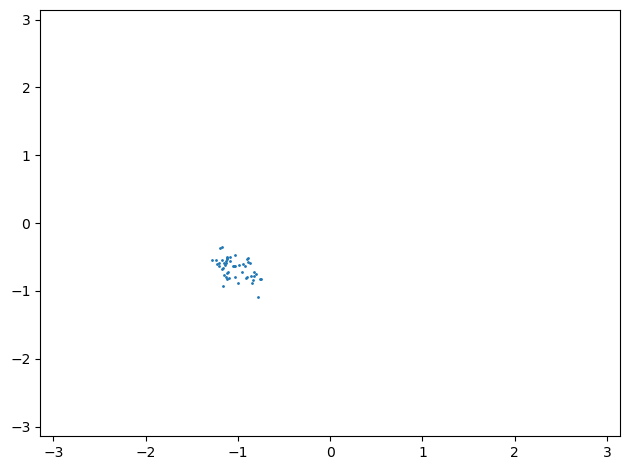

In [28]:
################################################################
# Plot (phi,psi) plots
################################################################
phi = pd.read_csv(directory + 'COLVAR_phi', skiprows = 19, delim_whitespace = True, header = None)
psi = pd.read_csv(directory + 'COLVAR_psi', skiprows = 19, delim_whitespace = True, header = None)

## plot for 5th residue. Note: dataframes contain time in the first column
fig, ax = plt.subplots()
ax.plot(phi.iloc[:,5], psi.iloc[:,5],'o', markersize = 1)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
fig.tight_layout()